Loading data from: anaphoric_ambiguity_spanbert_input.csv
Loaded 474 samples

INITIALIZING MODEL AND TOKENIZER


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'classifier.bias', 'bert.pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded AutoModelForSequenceClassification (2 classes)

DATA SPLITTING (STRATIFIED)

Dataset split: Total=474, Train=332, Val=71, Test=71

Class distribution per split:
Train: {'UA': 192, 'A': 139}
Val:   {'UA': 41, 'A': 30}
Test:  {'UA': 42, 'A': 30}

CLASS WEIGHT CALCULATION
Training class distribution:
Manual Evaluation
UA    192
A     139
Name: count, dtype: int64
Class weights: A=1.1906, UA=0.8620
Weight ratio: 1.38

CREATING DATASETS AND DATALOADERS
Train batches: 21
Val batches: 5
Test batches: 5

Using device: cpu
Total training steps: 420
Warmup steps: 42

STARTING TRAINING
  Epoch 1/20 - Batch 10/21 - Loss: 0.6870
  Epoch 1/20 - Batch 20/21 - Loss: 0.6851

Epoch 1/20 Summary:
  Train Loss: 0.6930
  Val Loss:   0.6878
  Val Acc:    0.6338
  Val F1:     0.5379
------------------------------------------------------------
New best model saved F1=0.5379
  Epoch 2/20 - Batch 10/21 - Loss: 0.6276
  Epoch 2/20 - Batch 20/21 - Loss: 0.6270

Epoch 2/20 Summary:
  Train Loss: 0.6610
  Va

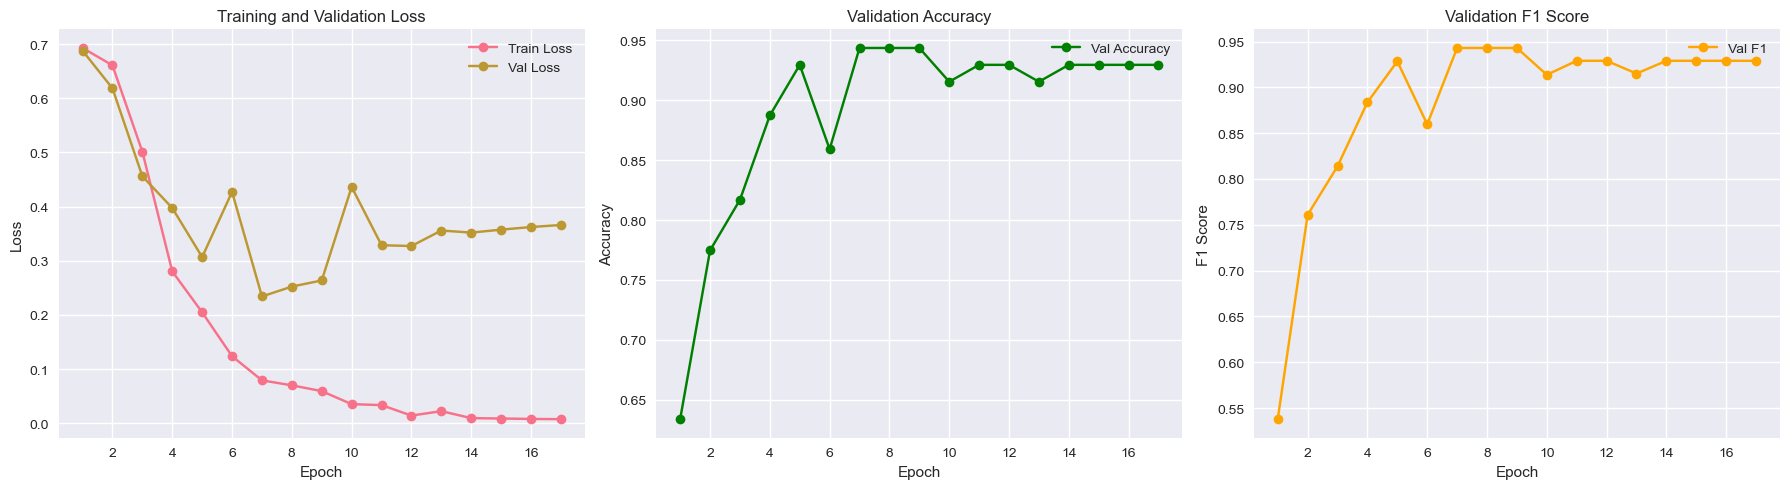


FINAL TEST SET EVALUATION


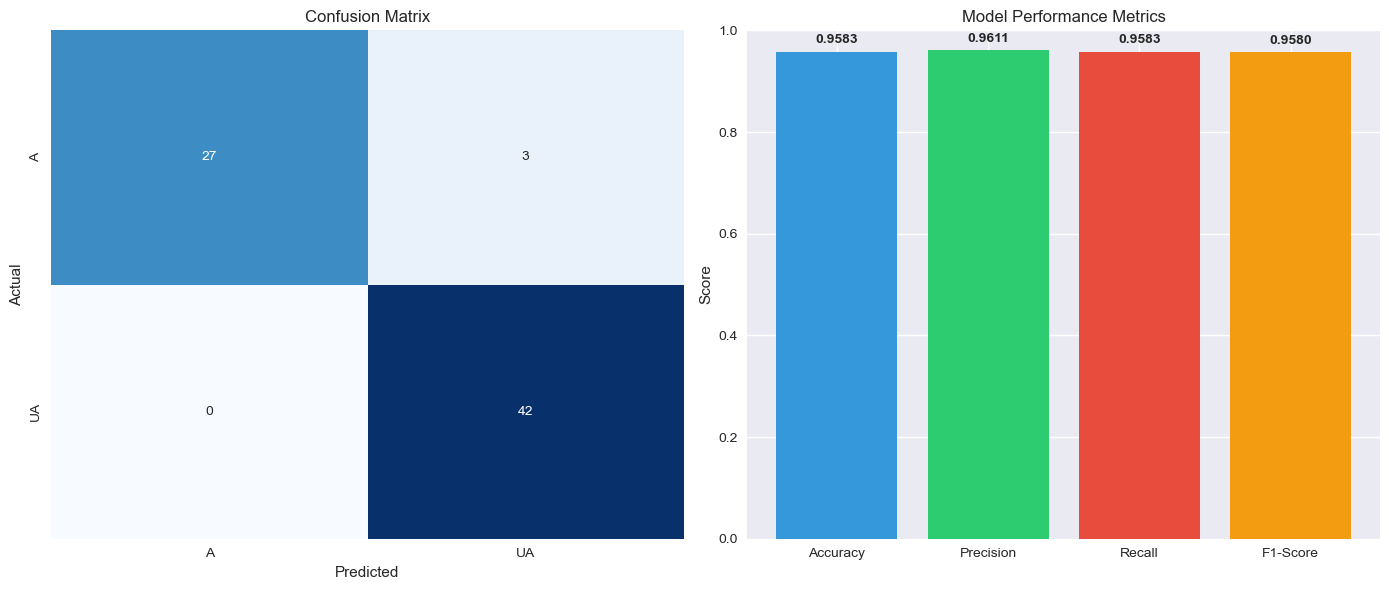


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A     1.0000    0.9000    0.9474        30
          UA     0.9333    1.0000    0.9655        42

    accuracy                         0.9583        72
   macro avg     0.9667    0.9500    0.9564        72
weighted avg     0.9611    0.9583    0.9580        72


ROC CURVE


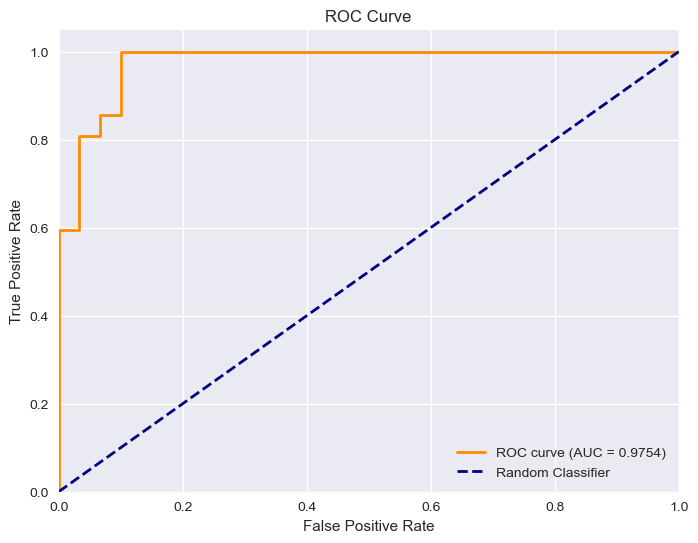


SAVING RESULTS
Saved test predictions to ./spanbert_anaphora_detection_final/test_predictions.csv
Saved metrics to ./spanbert_anaphora_detection_final/metrics_summary.csv
Saved model and tokenizer to ./spanbert_anaphora_detection_final

TRAINING COMPLETE
Best Epoch: 7
Test Accuracy: 0.9583
Test Precision: 0.9611
Test Recall: 0.9583
Test F1: 0.9580
Test AUC: 0.9754

PIPELINE COMPLETE
All results saved to: ./spanbert_anaphora_detection_final


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support, accuracy_score,
                             roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
import torch_directml
warnings.filterwarnings('ignore')

# -------------------------
# Config / Hyperparameters
# -------------------------
DATA_PATH = "../Preprocessing/anaphoric_ambiguity_spanbert_input.csv"
MODEL_DIR = "./spanbert_anaphora_detection_final"
BATCH_SIZE = 16
MAX_LENGTH = 128
NUM_EPOCHS = 10
LR = 2e-5
WARMUP_RATIO = 0.1             
RANDOM_SEED = 42
USE_MULTITASK = False
UPSAMPLE_TRAIN = False
EARLY_STOPPING_PATIENCE = 7     
EARLY_STOPPING_METRIC = "f1"   
GRAD_CLIP_NORM = 1.0
# try:
#     import torch_directml
#     DEVICE = torch_directml.device()
# except ImportError:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Data / Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    """
    Dataset for anaphora resolution.
    Expects columns: Hashed_Context, Pronoun, Candidate_Antecedent, Manual Evaluation
    """
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = f"{row['Hashed_Context']} [SEP] {row['Pronoun']} [SEP] {row['Candidate_Antecedent']}"
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        label = 1 if row['Manual Evaluation'] == 'UA' else 0
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
        return item

# -------------------------
# MultiTask Model
# -------------------------
class MultiTaskSpanBERT(nn.Module):
    """
    Multi-task SpanBERT with detection and resolution heads.
    """
    def __init__(self, pretrained="SpanBERT/spanbert-base-cased", hidden_size=768):
        super().__init__()
        self.spanbert = AutoModel.from_pretrained(pretrained)
        self.detection_head = nn.Linear(hidden_size, 2)
        self.resolution_head = nn.Linear(hidden_size, 2)

    def forward(self, input_ids=None, attention_mask=None):
        outputs = self.spanbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]  # CLS token
        detection_logits = self.detection_head(pooled)
        resolution_logits = self.resolution_head(pooled)
        return {'logits': detection_logits, 'resolution_logits': resolution_logits}

# -------------------------
# Utilities
# -------------------------
def calculate_class_weights(train_df):
    """
    Calculate proper class weights using sklearn's balanced approach.
    No normalization to avoid problems with balancing
    """
    print("\n" + "="*60)
    print("CLASS WEIGHT CALCULATION")
    print("="*60)
    
    class_counts = train_df['Manual Evaluation'].value_counts()
    print("Training class distribution:")
    print(class_counts)
    
    total = len(train_df)
    n_classes = 2
    
    # Sklearn's balanced approach: n_samples / (n_classes * n_samples_class)
    weights = {}
    for label, count in class_counts.items():
        count = class_counts.get(label, 1)  # Avoid division by zero
        weight = total / (n_classes * count)
        weights[0 if label == 'A' else 1] = weight
    
    # Check for extreme weights (to maybe prevent large imbalance)
    weight_ratio = max(weights.values()) / min(weights.values())    
    tensor = torch.tensor([weights[0], weights[1]], dtype=torch.float)
    print(f"Class weights: A={weights[0]:.4f}, UA={weights[1]:.4f}")
    print(f"Weight ratio: {weight_ratio:.2f}")
    
    return tensor

def create_data_splits(df, test_size=0.15, val_size=0.15, seed=RANDOM_SEED):
    """
    Stratified split into train/val/test.
    Validates minimum samples per class.
    """    
    # Calculate actual split sizes
    n = len(df)
    n_test = max(1, int(n * test_size))
    n_val = max(1, int(n * val_size))
    n_train = n - n_test - n_val
    
    print(f"\nDataset split: Total={n}, Train={n_train}, Val={n_val}, Test={n_test}")
    
    # Stratified splits
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, random_state=seed,
        stratify=df['Manual Evaluation']
    )
    
    val_ratio = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df, test_size=val_ratio, random_state=seed,
        stratify=train_val_df['Manual Evaluation']
    )
    
    # Verify splits
    print("\nClass distribution per split:")
    print("Train:", train_df['Manual Evaluation'].value_counts().to_dict())
    print("Val:  ", val_df['Manual Evaluation'].value_counts().to_dict())
    print("Test: ", test_df['Manual Evaluation'].value_counts().to_dict())
    
    return (train_df.reset_index(drop=True), 
            val_df.reset_index(drop=True), 
            test_df.reset_index(drop=True))

# -------------------------
# Evaluation
# -------------------------
def evaluate_model(model, dataloader, device):
    """
    Evaluation function.
    Returns: predictions, labels, probabilities
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            if batch['input_ids'].shape[0] == 0:
                continue

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Extract logits from various output formats
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            elif isinstance(outputs, dict) and 'logits' in outputs:
                logits = outputs['logits']
            elif isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            probs = torch.softmax(logits, dim=1)
            _, preds = torch.max(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def calculate_metrics(y_true, y_pred, y_probs=None):
    """
    Calculate comprehensive metrics.
    Returns dict with accuracy, precision, recall, f1, and optionally auc.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Calculate AUC if probabilities provided and both classes present
    if y_probs is not None and len(np.unique(y_true)) == 2:
        try:
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            metrics['auc'] = auc(fpr, tpr)
        except Exception:
            metrics['auc'] = None
    
    return metrics

# -------------------------
# Plotting
# -------------------------
def plot_training_history(history):
    """Plot training and validation metrics."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'o-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(epochs, history['val_acc'], 'o-', color='green', label='Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # F1 Score 
    if 'val_f1' in history:
        axes[2].plot(epochs, history['val_f1'], 'o-', color='orange', label='Val F1')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_title('Validation F1 Score')
        axes[2].legend()
        axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_and_metrics(y_true, y_pred, class_names=['A', 'UA']):
    """Plot confusion matrix and metrics."""
    metrics = calculate_metrics(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                ax=ax1, cbar=False)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix')
    
    # Metrics bar chart
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    
    bars = ax2.bar(metric_names, values, color=colors)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Score')
    ax2.set_title('Model Performance Metrics')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))
    
    return metrics

def plot_roc_curve(y_true, y_probs, class_names=['A', 'UA']):
    """Plot ROC curve."""   
    try:
        fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='navy', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        return roc_auc
    except Exception as e:
        print(f"Could not plot ROC curve: {e}")
        return None

# -------------------------
# Training Loop
# -------------------------
def fine_tune_with_evaluation(
        df,
        model_type="detection",
        use_multitask=USE_MULTITASK,
        upsample_train=UPSAMPLE_TRAIN,
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR,
        warmup_ratio=WARMUP_RATIO,
        model_dir=MODEL_DIR):
    """
    Main training function with proper scheduler, early stopping, and checkpointing.
    """
    print("\n" + "="*60)
    print("INITIALIZING MODEL AND TOKENIZER")
    print("="*60)
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")
    
    if model_type == "detection":
        model = AutoModelForSequenceClassification.from_pretrained(
            "SpanBERT/spanbert-base-cased", 
            num_labels=2
        )
        print("Loaded AutoModelForSequenceClassification (2 classes)")
    else:
        model = MultiTaskSpanBERT(pretrained="SpanBERT/spanbert-base-cased")
        print("Loaded MultiTaskSpanBERT")
    
    # Split data 
    print("\n" + "="*60)
    print("DATA SPLITTING (STRATIFIED)")
    print("="*60)
    
    train_df, val_df, test_df = create_data_splits(df, test_size=0.15, val_size=0.15, seed=RANDOM_SEED)
    
    # Calculate class weights
    class_weights = calculate_class_weights(train_df).to(DEVICE)
    
    # Create datasets and dataloaders
    print("\n" + "="*60)
    print("CREATING DATASETS AND DATALOADERS")
    print("="*60)
    
    train_dataset = AnaphoraDataset(train_df, tokenizer, max_length=MAX_LENGTH)
    val_dataset = AnaphoraDataset(val_df, tokenizer, max_length=MAX_LENGTH)
    test_dataset = AnaphoraDataset(test_df, tokenizer, max_length=MAX_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    # Move model to device
    model.to(DEVICE)
    print(f"\nUsing device: {DEVICE}")
    
    # Setup training components
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Setup scheduler with warmup
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(total_steps * warmup_ratio)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    print(f"Total training steps: {total_steps}")
    print(f"Warmup steps: {warmup_steps}")
    
    # Setup checkpointing
    os.makedirs(model_dir, exist_ok=True)
    best_checkpoint_path = os.path.join(model_dir, "best_model.pth")
    
    # Early stopping setup
    best_metric = 0.0
    patience_counter = 0
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Extract logits
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            elif isinstance(outputs, dict) and 'logits' in outputs:
                logits = outputs['logits']
            else:
                logits = outputs
            
            loss = loss_fn(logits, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP_NORM)
            
            optimizer.step()
            scheduler.step()
            
            total_train_loss += loss.item()
            
            # Progress logging
            if (batch_idx + 1) % 10 == 0:
                print(f"  Epoch {epoch+1}/{num_epochs} - Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")
        
        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        val_preds, val_labels, val_probs = evaluate_model(model, val_loader, DEVICE)
        val_metrics = calculate_metrics(val_labels, val_preds, val_probs)
        
        # Calculate val loss
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                elif isinstance(outputs, dict) and 'logits' in outputs:
                    logits = outputs['logits']
                else:
                    logits = outputs
                
                loss = loss_fn(logits, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        
        # Update history
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss:   {avg_val_loss:.4f}")
        print(f"  Val Acc:    {val_metrics['accuracy']:.4f}")
        print(f"  Val F1:     {val_metrics['f1']:.4f}")
        print("-" * 60)
        
        # Early stopping logic
        current_metric = val_metrics[EARLY_STOPPING_METRIC]
        
        if current_metric > best_metric:
            best_metric = current_metric
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_metric': best_metric,
                'history': history
            }, best_checkpoint_path)
            
            print(f"New best model saved {EARLY_STOPPING_METRIC.upper()}={best_metric:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                print(f"Best {EARLY_STOPPING_METRIC}: {best_metric:.4f}")
                break
    
    # Load best model
    print("\n" + "="*60)
    print("LOADING BEST MODEL FOR FINAL EVALUATION")
    print("="*60)
    
    checkpoint = torch.load(best_checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
    print(f"Best validation {EARLY_STOPPING_METRIC}: {checkpoint['best_metric']:.4f}")
    
    # Plot training history
    plot_training_history(history)
    
    # Final evaluation on test set
    print("\n" + "="*60)
    print("FINAL TEST SET EVALUATION")
    print("="*60)
    
    test_preds, test_labels, test_probs = evaluate_model(model, test_loader, DEVICE)
    
    if len(test_preds) == 0:
        print("ERROR: No predictions generated. Check test set and model.")
        return model, tokenizer, {}, test_preds, test_labels, test_probs, history
    
    # Calculate and plot metrics
    test_metrics = plot_confusion_matrix_and_metrics(test_labels, test_preds)
    
    # Plot ROC curve
    print("\n" + "="*60)
    print("ROC CURVE")
    print("="*60)
    auc_score = plot_roc_curve(test_labels, test_probs)
    if auc_score:
        test_metrics['auc'] = auc_score
    
    # Save results
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    # Save predictions
    results_df = pd.DataFrame({
        'true_label': test_labels,
        'predicted_label': test_preds,
        'probability_A': test_probs[:, 0],
        'probability_UA': test_probs[:, 1],
        'correct': test_labels == test_preds
    })
    results_df.to_csv(os.path.join(model_dir, "test_predictions.csv"), index=False)
    print(f"Saved test predictions to {model_dir}/test_predictions.csv")
    
    # Save metrics
    metrics_df = pd.DataFrame([{
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1'],
        'auc': test_metrics.get('auc', None),
        'best_epoch': checkpoint['epoch'] + 1
    }])
    metrics_df.to_csv(os.path.join(model_dir, "metrics_summary.csv"), index=False)
    print(f"Saved metrics to {model_dir}/metrics_summary.csv")
    
    # Save model and tokenizer
    if hasattr(model, "save_pretrained"):
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)
        print(f"Saved model and tokenizer to {model_dir}")
    
    # Print final summary
    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print("="*60)
    print(f"Best Epoch: {checkpoint['epoch']+1}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision: {test_metrics['precision']:.4f}")
    print(f"Test Recall: {test_metrics['recall']:.4f}")
    print(f"Test F1: {test_metrics['f1']:.4f}")
    if 'auc' in test_metrics:
        print(f"Test AUC: {test_metrics['auc']:.4f}")
    
    return model, tokenizer, test_metrics, test_preds, test_labels, test_probs, history

# -------------------------
# Run Pipeline
# -------------------------
if __name__ == "__main__":
    # Load data
    print("Loading data from:", DATA_PATH)
    final_df = pd.read_csv(DATA_PATH)
    print(f"Loaded {len(final_df)} samples")
    
    # Run training
    model, tokenizer, metrics, test_preds, test_labels, test_probs, history = fine_tune_with_evaluation(
        final_df,
        model_type="detection",
        use_multitask=USE_MULTITASK,
        upsample_train=UPSAMPLE_TRAIN,
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR,
        warmup_ratio=WARMUP_RATIO,
        model_dir=MODEL_DIR
    )
    
    print("\n" + "="*60)
    print("PIPELINE COMPLETE")
    print("="*60)
    print("All results saved to:", MODEL_DIR)


In [ ]:
# improved_spanbert_pipeline.py
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support, accuracy_score,
                             roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
import itertools

warnings.filterwarnings('ignore')

# -------------------------
# Config / Hyperparameters
# -------------------------
DATA_PATH = "anaphoric_ambiguity_spanbert_input.csv"
BASE_MODEL_DIR = "./spanbert_anaphora_detection_grid_search"
MAX_LENGTH = 128
WARMUP_RATIO = 0.1              # 10% of steps for warmup
RANDOM_SEED = 42
USE_MULTITASK = False
UPSAMPLE_TRAIN = False
EARLY_STOPPING_PATIENCE = 10     # Increased for stability
EARLY_STOPPING_METRIC = "f1"    # More robust than accuracy
GRAD_CLIP_NORM = 1.0
# try:
#     import torch_directml
#     DEVICE = torch_directml.device()
# except ImportError:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Data / Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    """
    Dataset for anaphora resolution.
    Expects columns: Hashed_Context, Pronoun, Candidate_Antecedent, Manual Evaluation
    """
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = f"{row['Hashed_Context']} [SEP] {row['Pronoun']} [SEP] {row['Candidate_Antecedent']}"
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        label = 1 if row['Manual Evaluation'] == 'UA' else 0
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
        # # Optional resolution label for multitask
        # if 'Resolution_Label' in row.index and not pd.isna(row['Resolution_Label']):
        #     item['resolution_label'] = torch.tensor(int(row['Resolution_Label']), dtype=torch.long)
        return item

# -------------------------
# MultiTask Model
# -------------------------
class MultiTaskSpanBERT(nn.Module):
    """
    Multi-task SpanBERT with detection and resolution heads.
    """
    def __init__(self, pretrained="SpanBERT/spanbert-base-cased", hidden_size=768):
        super().__init__()
        self.spanbert = AutoModel.from_pretrained(pretrained)
        self.detection_head = nn.Linear(hidden_size, 2)
        self.resolution_head = nn.Linear(hidden_size, 2)

    def forward(self, input_ids=None, attention_mask=None):
        outputs = self.spanbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]  # CLS token
        detection_logits = self.detection_head(pooled)
        resolution_logits = self.resolution_head(pooled)
        return {'logits': detection_logits, 'resolution_logits': resolution_logits}

# -------------------------
# Utilities
# -------------------------
def calculate_class_weights(train_df):
    """
    Calculate proper class weights using sklearn's balanced approach.
    No normalization to avoid problems with balancing
    """
    print("\n" + "="*60)
    print("CLASS WEIGHT CALCULATION")
    print("="*60)
    
    class_counts = train_df['Manual Evaluation'].value_counts()
    print("Training class distribution:")
    print(class_counts)
    
    total = len(train_df)
    n_classes = 2
    
    # Sklearn's balanced approach: n_samples / (n_classes * n_samples_class)
    weights = {}
    for label, count in class_counts.items():
        count = class_counts.get(label, 1)  # Avoid division by zero
        weight = total / (n_classes * count)
        weights[0 if label == 'A' else 1] = weight
    
    # Check for extreme weights (to maybe prevent large imbalance)
    weight_ratio = max(weights.values()) / min(weights.values())    
    tensor = torch.tensor([weights[0], weights[1]], dtype=torch.float)
    print(f"Class weights: A={weights[0]:.4f}, UA={weights[1]:.4f}")
    print(f"Weight ratio: {weight_ratio:.2f}")
    
    return tensor

def create_data_splits(df, test_size=0.15, val_size=0.15, seed=RANDOM_SEED):
    """
    Stratified split into train/val/test.
    Validates minimum samples per class.
    """    
    # Calculate actual split sizes
    n = len(df)
    n_test = max(1, int(n * test_size))
    n_val = max(1, int(n * val_size))
    n_train = n - n_test - n_val
    
    print(f"\nDataset split: Total={n}, Train={n_train}, Val={n_val}, Test={n_test}")
    
    # Stratified splits
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, random_state=seed,
        stratify=df['Manual Evaluation']
    )
    
    val_ratio = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df, test_size=val_ratio, random_state=seed,
        stratify=train_val_df['Manual Evaluation']
    )
    
    # Verify splits
    print("\nClass distribution per split:")
    print("Train:", train_df['Manual Evaluation'].value_counts().to_dict())
    print("Val:  ", val_df['Manual Evaluation'].value_counts().to_dict())
    print("Test: ", test_df['Manual Evaluation'].value_counts().to_dict())
    
    return (train_df.reset_index(drop=True), 
            val_df.reset_index(drop=True), 
            test_df.reset_index(drop=True))

# -------------------------
# Evaluation
# -------------------------
def evaluate_model(model, dataloader, device):
    """
    Evaluation function.
    Returns: predictions, labels, probabilities
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            if batch['input_ids'].shape[0] == 0:
                continue

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Extract logits from various output formats
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            elif isinstance(outputs, dict) and 'logits' in outputs:
                logits = outputs['logits']
            elif isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            probs = torch.softmax(logits, dim=1)
            _, preds = torch.max(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def calculate_metrics(y_true, y_pred, y_probs=None):
    """
    Calculate comprehensive metrics.
    Returns dict with accuracy, precision, recall, f1, and optionally auc.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Calculate AUC if probabilities provided and both classes present
    if y_probs is not None and len(np.unique(y_true)) == 2:
        try:
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            metrics['auc'] = auc(fpr, tpr)
        except Exception:
            metrics['auc'] = None
    
    return metrics

# -------------------------
# Plotting
# -------------------------
def plot_training_history(history, model_dir):
    """Plot training and validation metrics."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'o-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(epochs, history['val_acc'], 'o-', color='green', label='Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # F1 Score 
    if 'val_f1' in history:
        axes[2].plot(epochs, history['val_f1'], 'o-', color='orange', label='Val F1')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_title('Validation F1 Score')
        axes[2].legend()
        axes[2].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, "training_history.png"))
    plt.show()

def plot_confusion_matrix_and_metrics(y_true, y_pred, model_dir, class_names=['A', 'UA']):
    """Plot confusion matrix and metrics."""
    metrics = calculate_metrics(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                ax=ax1, cbar=False)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix')
    
    # Metrics bar chart
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    
    bars = ax2.bar(metric_names, values, color=colors)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Score')
    ax2.set_title('Model Performance Metrics')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, "confusion_matrix_and_metrics.png"))
    plt.show()
    
    # Print detailed report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))
    
    return metrics

def plot_roc_curve(y_true, y_probs, model_dir, class_names=['A', 'UA']):
    """Plot ROC curve."""   
    try:
        fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='navy', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig(os.path.join(model_dir, "roc_curve.png"))
        plt.show()
        
        return roc_auc
    except Exception as e:
        print(f"Could not plot ROC curve: {e}")
        return None

# -------------------------
# Training Loop
# -------------------------
def fine_tune_with_evaluation(
        df,
        model_type="detection",
        use_multitask=USE_MULTITASK,
        upsample_train=UPSAMPLE_TRAIN,
        num_epochs=10,
        batch_size=16,
        lr=2e-5,
        warmup_ratio=WARMUP_RATIO,
        model_dir=BASE_MODEL_DIR):
    """
    Main training function with proper scheduler, early stopping, and checkpointing.
    """
    print("\n" + "="*80)
    print(f"STARTING TRAINING RUN with lr={lr}, epochs={num_epochs}, batch_size={batch_size}")
    print("="*80)
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")
    
    if model_type == "detection":
        model = AutoModelForSequenceClassification.from_pretrained(
            "SpanBERT/spanbert-base-cased", 
            num_labels=2
        )
    else:
        model = MultiTaskSpanBERT(pretrained="SpanBERT/spanbert-base-cased")
    
    # Split data 
    train_df, val_df, test_df = create_data_splits(df, test_size=0.15, val_size=0.15, seed=RANDOM_SEED)
    
    # Calculate class weights
    class_weights = calculate_class_weights(train_df).to(DEVICE)
    
    # Create datasets and dataloaders
    train_dataset = AnaphoraDataset(train_df, tokenizer, max_length=MAX_LENGTH)
    val_dataset = AnaphoraDataset(val_df, tokenizer, max_length=MAX_LENGTH)
    test_dataset = AnaphoraDataset(test_df, tokenizer, max_length=MAX_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Move model to device
    model.to(DEVICE)
    
    # Setup training components
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Setup scheduler with warmup
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(total_steps * warmup_ratio)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Setup checkpointing
    os.makedirs(model_dir, exist_ok=True)
    best_checkpoint_path = os.path.join(model_dir, "best_model.pth")
    
    # Early stopping setup
    best_metric = 0.0
    patience_counter = 0
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            elif isinstance(outputs, dict) and 'logits' in outputs:
                logits = outputs['logits']
            else:
                logits = outputs
            
            loss = loss_fn(logits, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP_NORM)
            
            optimizer.step()
            scheduler.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        val_preds, val_labels, val_probs = evaluate_model(model, val_loader, DEVICE)
        val_metrics = calculate_metrics(val_labels, val_preds, val_probs)
        
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                elif isinstance(outputs, dict) and 'logits' in outputs:
                    logits = outputs['logits']
                else:
                    logits = outputs
                
                loss = loss_fn(logits, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / (len(val_loader) if len(val_loader) > 0 else 1)

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_metrics['accuracy']:.4f} | Val F1: {val_metrics['f1']:.4f}")
        
        current_metric = val_metrics[EARLY_STOPPING_METRIC]
        
        if current_metric > best_metric:
            best_metric = current_metric
            patience_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_metric': best_metric,
                'history': history
            }, best_checkpoint_path)
            
            print(f"  New best model saved with {EARLY_STOPPING_METRIC.upper()}={best_metric:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    checkpoint = torch.load(best_checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    plot_training_history(history, model_dir)
    
    # Final evaluation on test set
    test_preds, test_labels, test_probs = evaluate_model(model, test_loader, DEVICE)
    
    if len(test_preds) == 0:
        print("ERROR: No predictions generated.")
        return model, tokenizer, {}, test_preds, test_labels, test_probs, history
    
    test_metrics = plot_confusion_matrix_and_metrics(test_labels, test_preds, model_dir)
    auc_score = plot_roc_curve(test_labels, test_probs, model_dir)
    if auc_score:
        test_metrics['auc'] = auc_score
    
    # Save results
    results_df = pd.DataFrame({
        'true_label': test_labels,
        'predicted_label': test_preds,
        'probability_A': test_probs[:, 0],
        'probability_UA': test_probs[:, 1],
        'correct': test_labels == test_preds
    })
    results_df.to_csv(os.path.join(model_dir, "test_predictions.csv"), index=False)
    
    metrics_df = pd.DataFrame([{
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1'],
        'auc': test_metrics.get('auc', None),
        'best_epoch': checkpoint['epoch'] + 1
    }])
    metrics_df.to_csv(os.path.join(model_dir, "metrics_summary.csv"), index=False)
    
    if hasattr(model, "save_pretrained"):
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)
    
    print("\n" + "="*60)
    print("TRAINING RUN COMPLETE")
    print(f"Results saved to: {model_dir}")
    print("="*60)
    
    return test_metrics

# -------------------------
# Grid Search Pipeline
# -------------------------
if __name__ == "__main__":
    # Load data
    print("Loading data from:", DATA_PATH)
    final_df = pd.read_csv(DATA_PATH)
    print(f"Loaded {len(final_df)} samples")
    
    # Define the hyperparameter grid
    param_grid = {
        'lr': [2e-5, 3e-5, 5e-5],
        'num_epochs': [5, 10, 15],
        'batch_size': [16, 32]
    }
    
    all_results = []
    
    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"\nStarting Grid Search with {len(hyperparameter_combinations)} combinations...")
    
    for i, params in enumerate(hyperparameter_combinations):
        lr = params['lr']
        num_epochs = params['num_epochs']
        batch_size = params['batch_size']
        
        # Create a unique directory for each run
        model_dir = os.path.join(BASE_MODEL_DIR, f"run_{i+1}_lr_{lr}_epochs_{num_epochs}_bs_{batch_size}")
        
        # Run the training and evaluation
        test_metrics = fine_tune_with_evaluation(
            final_df,
            model_type="detection",
            use_multitask=USE_MULTITASK,
            upsample_train=UPSAMPLE_TRAIN,
            num_epochs=num_epochs,
            batch_size=batch_size,
            lr=lr,
            warmup_ratio=WARMUP_RATIO,
            model_dir=model_dir
        )
        
        # Store the results
        run_results = {
            'run': i+1,
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'test_f1': test_metrics.get('f1', 0),
            'test_accuracy': test_metrics.get('accuracy', 0),
            'model_dir': model_dir
        }
        all_results.append(run_results)

    # Find the best run
    if all_results:
        best_run = max(all_results, key=lambda x: x['test_f1'])
        
        print("\n" + "="*80)
        print("GRID SEARCH COMPLETE")
        print("="*80)
        print(f"Best run was Run #{best_run['run']} with a Test F1-score of {best_run['test_f1']:.4f}")
        print("Best Hyperparameters:")
        print(f"  - Learning Rate: {best_run['learning_rate']}")
        print(f"  - Number of Epochs: {best_run['num_epochs']}")
        print(f"  - Batch Size: {best_run['batch_size']}")
        print(f"  - Model and results saved in: {best_run['model_dir']}")
        
        # Save summary of all runs
        results_summary_df = pd.DataFrame(all_results)
        results_summary_df.to_csv(os.path.join(BASE_MODEL_DIR, "grid_search_summary.csv"), index=False)
        print(f"\nGrid search summary saved to: {os.path.join(BASE_MODEL_DIR, 'grid_search_summary.csv')}")
    else:
        print("\nGrid search completed with no results.")